In [1]:
import pandas as pd
import numpy as np
import glob
from svv_read import Sub_SVV
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
pd.options.display.max_rows = 10

In [3]:
# create data frame for results3
df = pd.DataFrame()

readfolder = '../DATA/EXP2/'
list_subject = glob.glob(readfolder+'/S*')
# list_subject

## check following outliers

 - check S50: -20º values (bucket moved during test)
 - check S45: very high angle and very short RT
 - check S46: similar S45
 - check S47: low angles

In [4]:
for sub in list_subject:
    SUB = Sub_SVV(sub)
    df = df.append(SUB.create_table(), ignore_index=True)


In [5]:
# snb.stripplot(x='freq', y='SVV', data = df)
# snb.stripplot(x='freq', y='SVV', data = df[(df['stim']=='SH') & (df['SVV']>2.5)])

## check for Subjective Visual Vesrtical over 2.5º in control condition

In [6]:
outliers = [(np.abs(df.loc[i,'SVV'])>2.5) and (df.loc[i,'stim']=='SH') for i in df.index]
bad_id = df[outliers].id.unique()
df.insert(len(df.columns), 'Outliers', df['id'].isin(bad_id))

## graphical representation of SVV data with outliers in red

In [7]:
bool_good_id = ~df['id'].isin(bad_id)
bool_SHDC = df['freq'] == 0  # select CTRL and DC stimulation

if False:    
    plt.figure()
    plt.subplot2grid((2,3),(0,0), rowspan=2)
    plt.plot(df[bool_SHDC].stim, df[bool_SHDC].SVV, 'o', label='All')
    plt.plot(df[bool_SHDC & ~bool_good_id].stim, df[bool_SHDC & ~bool_good_id].SVV, 'r.', ms=5, label='Outliers')
    plt.fill_between(['DC', 'SH'], [2.5, 2.5], -2.5, alpha=0.5, color='grey')
    plt.legend

    plt.title('Reference conditions')
    plt.xlabel('Stimulation')
    plt.ylabel('SVV (º)')

    plt.subplot2grid((2,3),(0,1), colspan=2)
    plt.plot(df[~bool_SHDC & (df['stim']=='AC')].freq, df[~bool_SHDC & (df['stim']=='AC')].SVV, 'o', alpha=0.4)
    plt.plot(df[~bool_SHDC & ~bool_good_id & (df['stim']=='AC')].freq, df[~bool_SHDC & ~bool_good_id & (df['stim']=='AC')].SVV, 'r.', ms=5)
    plt.fill_between([20, 160], [2.5, 2.5], -2.5, alpha=0.5, color='grey')

    plt.title('AC')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('SVV (º)')

    plt.subplot2grid((2,3),(1,1), colspan=2)
    plt.plot(df[~bool_SHDC & (df['stim']=='MF')].freq, df[~bool_SHDC & (df['stim']=='MF')].SVV, 'o', alpha=0.4)
    plt.plot(df[~bool_SHDC & ~bool_good_id & (df['stim']=='MF')].freq, df[~bool_SHDC & ~bool_good_id & (df['stim']=='MF')].SVV, 'r.', ms=5)
    plt.fill_between([20, 160], [2.5, 2.5], -2.5, alpha=0.5, color='grey')

    plt.title('MF')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('SVV (º)')

# Analysis over "good participants"

In [8]:
ndf = df[bool_good_id]  # remove subject with outliers SHAM data
ndf.insert(len(ndf.columns),'RT_deg',ndf['Reaction_time']/ndf['Angle_init'])  # create Time/deg column
ndf = ndf.drop(columns=['Angle_init','Reaction_time','Outliers'])
ndf = ndf.groupby(['id','stim','freq']).mean()

ref_svv = ndf.query('stim == "SH"')

In [9]:
ref_svv

,,,SVV,RT_deg
id,stim,freq,,
S40,SH,0.0,-0.133333,-208.146214
S41,SH,0.0,0.154135,-234.387189
S42,SH,0.0,-0.352208,-342.433534
S43,SH,0.0,-0.125796,-246.017915
S44,SH,0.0,-0.527896,-207.852142
...,...,...,...,...
S68,SH,0.0,-0.663784,-167.427528
S69,SH,0.0,-1.179175,-533.652934
S70,SH,0.0,-0.779787,-236.294071


## create new table with delta-SVV as difference SVVcond - SVVctrl

In [10]:
to_subtract = ref_svv.reset_index(level=[1,2], drop=True)
to_subtract

,SVV,RT_deg
id,,
S40,-0.133333,-208.146214
S41,0.154135,-234.387189
S42,-0.352208,-342.433534
S43,-0.125796,-246.017915
S44,-0.527896,-207.852142
...,...,...
S68,-0.663784,-167.427528
S69,-1.179175,-533.652934
S70,-0.779787,-236.294071


In [11]:
delta_svv = ndf.sub(to_subtract,axis=0, level=0)
delta_svv.head()

SVV     RT_deg
id  stim freq                      
S40 AC   20.0  -0.675000 -14.781405
         60.0  -0.033333  26.559257
         120.0 -0.050000   1.334726
         160.0 -0.108333  -6.586047
    DC   0.0   -0.091667  15.188827

In [12]:
import seaborn as sns

/Users/sebastienvillard/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [16]:
delta_svv.reset_index(level=['stim', 'freq'], inplace=True)
delta_svv.head()

,stim,freq,SVV,RT_deg
id,,,,
S40,AC,20.0,-0.675000,-14.781405
S40,AC,60.0,-0.033333,26.559257
S40,AC,120.0,-0.050000,1.334726
S40,AC,160.0,-0.108333,-6.586047
S40,DC,0.0,-0.091667,15.188827


/Users/sebastienvillard/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/Users/sebastienvillard/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the swarmplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/Users/sebastienvillard/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/Users/sebastienvillard/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the swarmplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


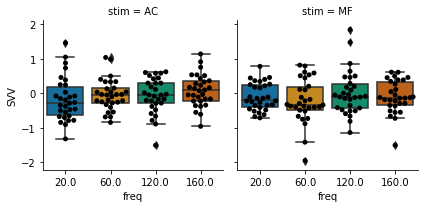

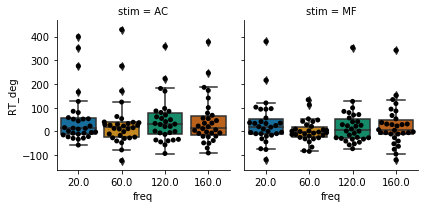

In [17]:
data = delta_svv.query('freq != 0 & stim != "MX"')

g = sns.FacetGrid(data, col='stim')  # check sns.catplot
g.map(sns.boxplot, 'freq', 'SVV', palette='colorblind')
g.map(sns.swarmplot, 'freq', 'SVV', color='black')

h = sns.FacetGrid(data, col='stim')
h.map(sns.boxplot, 'freq', 'RT_deg', palette='colorblind')
h.map(sns.swarmplot, 'freq', 'RT_deg', color='black')

# sns.boxplot(x='freq', y='SVV', data=data, hue='stim', palette='colorblind')
# sns.swarmplot(x='freq', y='SVV', data=data, hue='stim')

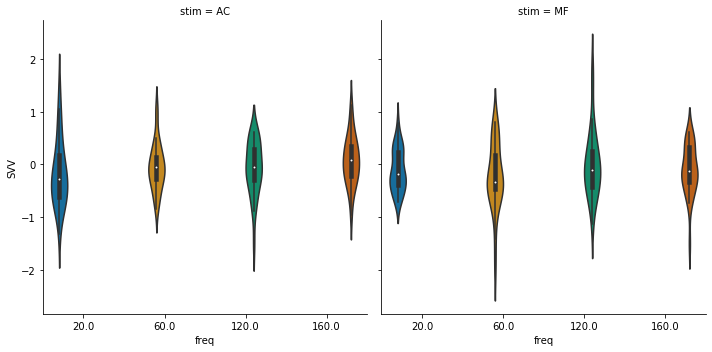

In [18]:
sns.catplot(data=data,
           kind='violin',
           x='freq',
           y='SVV',
           col='stim',
           hue='freq',
           palette='colorblind')